In [5]:
import sys
print(sys.executable)


c:\Users\myasu\AppData\Local\Programs\Python\Python313\python.exe


In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.colors import LinearSegmentedColormap



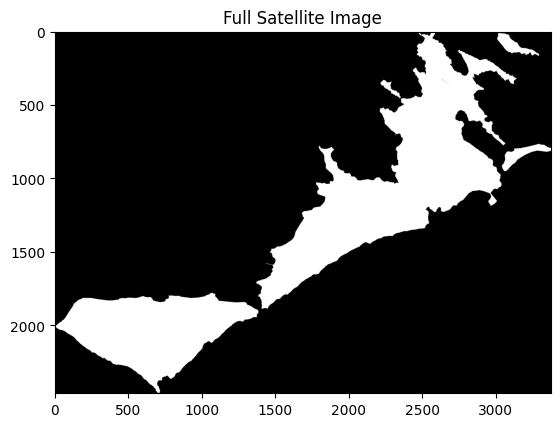

In [2]:
image_path = "NDVI KERKENNAH.tif"

with rasterio.open(image_path) as src:
    image = src.read(1)  # Read the first band (grayscale or NDVI)
    plt.imshow(image, cmap='gray')
    plt.title("Full Satellite Image")
    plt.show()

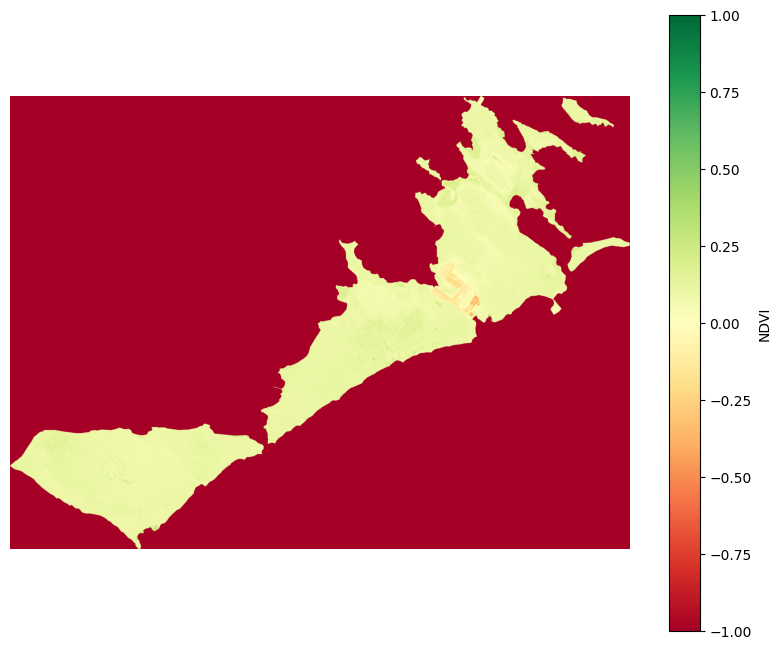

Image color√©e sauvegard√©e sous : c:\Users\myasu\Desktop\Stage Isitcom\NDVI_Kerkennah_colored.png


In [3]:
image_path = "NDVI KERKENNAH.tif"
output_image = "NDVI_Kerkennah_colored.png"

# Lire l'image NDVI (une seule bande)
with rasterio.open(image_path) as src:
    ndvi = src.read(1)

# Remplacer les valeurs invalides par -1 (optionnel)
ndvi = ndvi.astype(float)
ndvi[np.isnan(ndvi)] = -1

# Afficher et sauvegarder avec fausses couleurs
plt.figure(figsize=(10, 8))
plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(label='NDVI')
plt.axis('off')

# Sauvegarder l‚Äôimage color√©e
plt.savefig(output_image, bbox_inches='tight', pad_inches=0)
plt.show()

print(f"Image color√©e sauvegard√©e sous : {os.path.abspath(output_image)}")

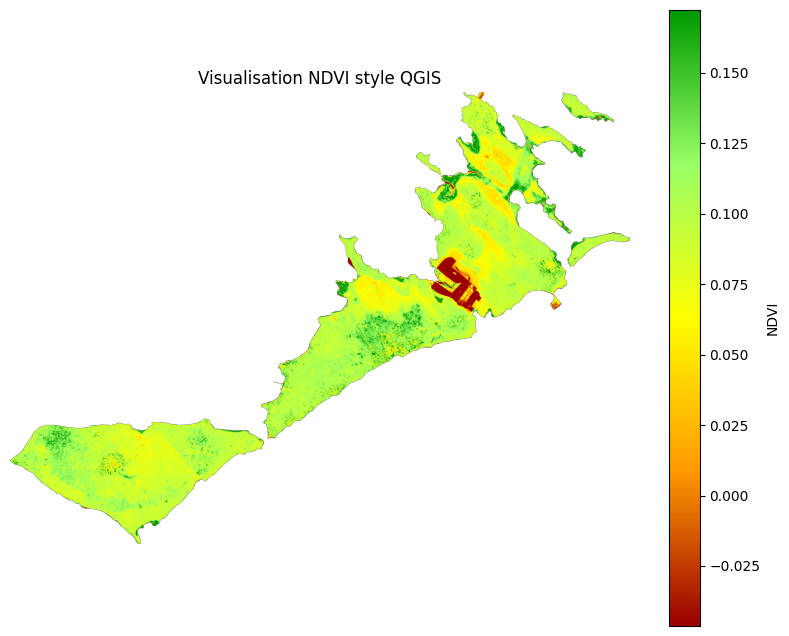

In [4]:


image_path = "NDVI KERKENNAH.tif"

with rasterio.open(image_path) as src:
    ndvi = src.read(1).astype(float)
    ndvi[ndvi == src.nodata] = np.nan  # g√©rer les valeurs nodata

# Limiter les valeurs NDVI entre -1 et 1
ndvi = np.clip(ndvi, -1, 1)

# √âtirer le contraste entre 2e et 98e percentile (comme QGIS)
vmin, vmax = np.nanpercentile(ndvi, 2), np.nanpercentile(ndvi, 98)

# Palette type QGIS NDVI (rouge ‚Üí jaune ‚Üí vert)
colors = [
    (0.6, 0, 0),       # rouge fonc√©
    (1, 0.6, 0),       # orange
    (1, 1, 0),         # jaune
    (0.6, 1, 0.4),     # vert clair
    (0, 0.6, 0),       # vert
]
ndvi_cmap = LinearSegmentedColormap.from_list("ndvi_cmap", colors, N=256)

plt.figure(figsize=(10, 8))
im = plt.imshow(ndvi, cmap=ndvi_cmap, vmin=vmin, vmax=vmax)
plt.colorbar(im, label='NDVI')
plt.axis('off')
plt.title("Visualisation NDVI style QGIS")
plt.show()


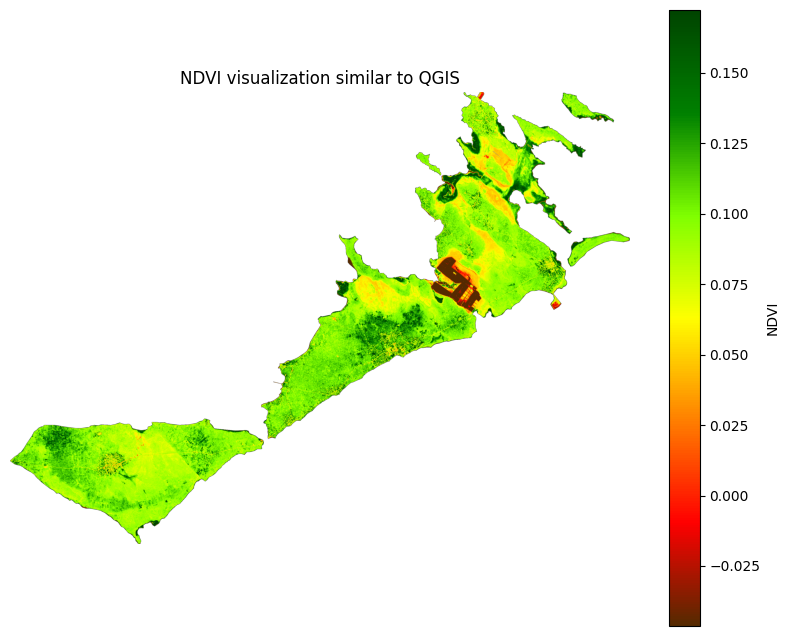

In [5]:

image_path = "NDVI KERKENNAH.tif"

with rasterio.open(image_path) as src:
    ndvi = src.read(1).astype(float)
    ndvi[ndvi == src.nodata] = np.nan

ndvi = np.clip(ndvi, -1, 1)

# Stretch contrast between 2nd and 98th percentile
vmin, vmax = np.nanpercentile(ndvi, 2), np.nanpercentile(ndvi, 98)

# QGIS NDVI colors as hex codes
colors_hex = [
    '#552A00',  # dark brown
    '#FF0000',  # red
    '#FF7F00',  # orange
    '#FFFF00',  # yellow
    '#7FFF00',  # light green
    '#008000',  # green
    '#004400'   # dark green
]

ndvi_cmap = LinearSegmentedColormap.from_list('qgis_ndvi', colors_hex, N=256)

plt.figure(figsize=(10,8))
im = plt.imshow(ndvi, cmap=ndvi_cmap, vmin=vmin, vmax=vmax)
plt.colorbar(im, label='NDVI')
plt.axis('off')
plt.title('NDVI visualization similar to QGIS')
plt.show()


In [6]:
import numpy as np

def split_image_into_zones(image_path, block_size=256):
    zones = []
    height, width = image.shape
    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            zone = image[i:i+block_size, j:j+block_size]
            if zone.shape == (block_size, block_size):
                zones.append(zone)
    return zones


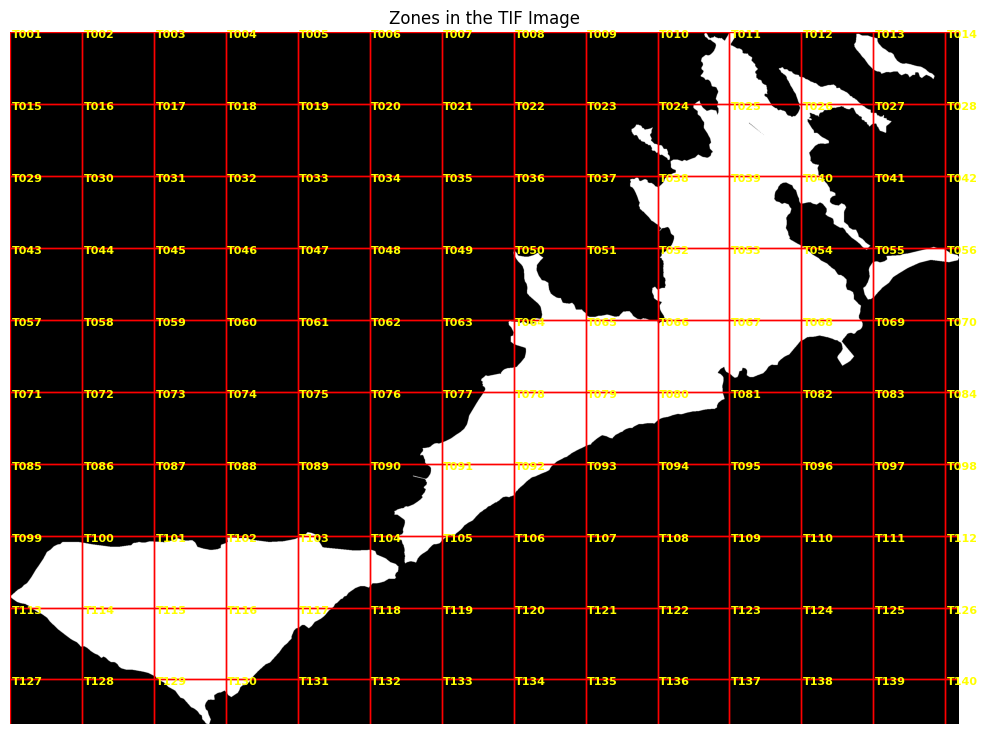

In [7]:

from matplotlib import patches


with rasterio.open(image_path) as src:
    image = src.read(1)  # Read first band (grayscale or NDVI)
    height, width = image.shape

# Step 2: Define zone size (in pixels)
block_size = 256

# Step 3: Show image + overlay zones
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image, cmap='gray')

zone_id = 1
for i in range(0, height, block_size):
    for j in range(0, width, block_size):
        # Draw rectangle for each zone
        rect = patches.Rectangle((j, i), block_size, block_size,
                                 linewidth=1, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

        # Optional: label each zone
        label = f"T{zone_id:03}"
        ax.text(j + 5, i + 20, label, color='yellow', fontsize=8, weight='bold')
        zone_id += 1

ax.set_title("Zones in the TIF Image")
ax.axis('off')
plt.tight_layout()
plt.show()

In [8]:
with rasterio.open(image_path) as src:
    ndvi = src.read(1)
    print("NDVI min:", np.min(ndvi))
    print("NDVI max:", np.max(ndvi))

NDVI min: -3.4028235e+38
NDVI max: 0.5061241


In [9]:
import rasterio
import numpy as np
import json
from datetime import date

INVALID = -3.4028235e+38
block_size = 256
zone_id = 1
certificates = []

with rasterio.open(image_path) as src:
    ndvi = src.read(1)
    height, width = ndvi.shape

    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            zone = ndvi[i:i+block_size, j:j+block_size]
            if zone.shape != (block_size, block_size):
                continue  

            zone_clean = zone[(zone > -1.0) & (zone <= 1.0)]  

            if zone_clean.size == 0:
                continue  

            mean_ndvi = float(np.mean(zone_clean))
            if mean_ndvi > 0.5:
                  status = "Highly Suitable"
            elif mean_ndvi > 0.3:
              status = "Suitable"
            else:
              status = "Not Suitable"



            # Build certificate
            terrain_id = f"T{zone_id:03}"
            cert = {
                "terrain_id": terrain_id,
                "mean_ndvi": round(mean_ndvi, 4),
                "status": status,
                "date": str(date.today())
            }

            import os
            os.makedirs("certificates", exist_ok=True)

            with open(f"certificates/{terrain_id}_certificate.json", "w") as f:
                json.dump(cert, f, indent=4)


            certificates.append(cert)
            zone_id += 1
            print(f"{terrain_id} ‚Üí NDVI: {mean_ndvi:.3f} ‚Üí {status}")

# Optionally save all in one file
with open("all_certificates.json", "w") as f:
    json.dump(certificates, f, indent=4)

print(f"‚úÖ {zone_id-1} zones processed.")


T001 ‚Üí NDVI: 0.095 ‚Üí Not Suitable
T002 ‚Üí NDVI: 0.095 ‚Üí Not Suitable
T003 ‚Üí NDVI: 0.096 ‚Üí Not Suitable
T004 ‚Üí NDVI: 0.105 ‚Üí Not Suitable
T005 ‚Üí NDVI: 0.097 ‚Üí Not Suitable
T006 ‚Üí NDVI: 0.109 ‚Üí Not Suitable
T007 ‚Üí NDVI: 0.081 ‚Üí Not Suitable
T008 ‚Üí NDVI: 0.105 ‚Üí Not Suitable
T009 ‚Üí NDVI: 0.156 ‚Üí Not Suitable
T010 ‚Üí NDVI: 0.099 ‚Üí Not Suitable
T011 ‚Üí NDVI: 0.094 ‚Üí Not Suitable
T012 ‚Üí NDVI: 0.088 ‚Üí Not Suitable
T013 ‚Üí NDVI: 0.106 ‚Üí Not Suitable
T014 ‚Üí NDVI: -0.089 ‚Üí Not Suitable
T015 ‚Üí NDVI: 0.092 ‚Üí Not Suitable
T016 ‚Üí NDVI: 0.110 ‚Üí Not Suitable
T017 ‚Üí NDVI: 0.048 ‚Üí Not Suitable
T018 ‚Üí NDVI: 0.084 ‚Üí Not Suitable
T019 ‚Üí NDVI: 0.105 ‚Üí Not Suitable
T020 ‚Üí NDVI: 0.100 ‚Üí Not Suitable
T021 ‚Üí NDVI: 0.098 ‚Üí Not Suitable
T022 ‚Üí NDVI: 0.092 ‚Üí Not Suitable
T023 ‚Üí NDVI: 0.095 ‚Üí Not Suitable
T024 ‚Üí NDVI: 0.018 ‚Üí Not Suitable
T025 ‚Üí NDVI: 0.091 ‚Üí Not Suitable
T026 ‚Üí NDVI: 0.086 ‚Üí Not Suitable
T027 ‚Üí ND

In [10]:
import rasterio
import numpy as np
import json
import os
from datetime import date

# Setup
INVALID = -3.4028235e+38
block_size = 256
zone_id = 1
certificates = []

os.makedirs("certificates", exist_ok=True)

# Load NDVI data
with rasterio.open(image_path) as src:  # replace with your actual image path
    ndvi = src.read(1)
    transform = src.transform
    height, width = ndvi.shape

    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            zone = ndvi[i:i+block_size, j:j+block_size]
            if zone.shape != (block_size, block_size):
                continue

            # Filter invalid values
            zone_clean = zone[(zone > -1.0) & (zone <= 1.0)]
            if zone_clean.size < (block_size * block_size * 0.5):
                continue  # Skip if more than 50% is invalid

            # Calculate NDVI
            mean_ndvi = float(np.mean(zone_clean))
            if mean_ndvi > 0.5:
                status = "Highly Suitable"
            elif mean_ndvi > 0.3:
                status = "Suitable"
            else:
                status = "Not Suitable"

            # Get center coordinates
            center_row = i + block_size // 2
            center_col = j + block_size // 2
            lon, lat = rasterio.transform.xy(transform, center_row, center_col)

            # Build certificate
            terrain_id = f"T{zone_id:03}"
            cert = {
                "terrain_id": terrain_id,
                "mean_ndvi": round(mean_ndvi, 4),
                "status": status,
                "date": str(date.today()),
                "center_lat": round(lat, 6),
                "center_lon": round(lon, 6),
                "row": i // block_size,
                "col": j // block_size
            }

            # Save individual certificate
            with open(f"certificates/{terrain_id}_certificate.json", "w") as f:
                json.dump(cert, f, indent=4)

            certificates.append(cert)
            print(f"{terrain_id} ‚Üí NDVI: {mean_ndvi:.3f} ‚Üí {status} @ ({lat:.5f}, {lon:.5f})")
            zone_id += 1

# Save all certificates in one file
with open("all_certificates.json", "w") as f:
    json.dump(certificates, f, indent=4)

print(f"‚úÖ {zone_id - 1} zones processed.")


T001 ‚Üí NDVI: 0.081 ‚Üí Not Suitable @ (3852815.00000, 707585.00000)
T002 ‚Üí NDVI: 0.094 ‚Üí Not Suitable @ (3850255.00000, 705025.00000)
T003 ‚Üí NDVI: 0.088 ‚Üí Not Suitable @ (3850255.00000, 707585.00000)
T004 ‚Üí NDVI: 0.048 ‚Üí Not Suitable @ (3847695.00000, 705025.00000)
T005 ‚Üí NDVI: 0.084 ‚Üí Not Suitable @ (3847695.00000, 707585.00000)
T006 ‚Üí NDVI: 0.105 ‚Üí Not Suitable @ (3847695.00000, 710145.00000)
T007 ‚Üí NDVI: 0.092 ‚Üí Not Suitable @ (3845135.00000, 699905.00000)
T008 ‚Üí NDVI: 0.095 ‚Üí Not Suitable @ (3845135.00000, 702465.00000)
T009 ‚Üí NDVI: 0.018 ‚Üí Not Suitable @ (3845135.00000, 705025.00000)
T010 ‚Üí NDVI: 0.091 ‚Üí Not Suitable @ (3845135.00000, 707585.00000)
T011 ‚Üí NDVI: 0.100 ‚Üí Not Suitable @ (3842575.00000, 697345.00000)
T012 ‚Üí NDVI: 0.115 ‚Üí Not Suitable @ (3842575.00000, 699905.00000)
T013 ‚Üí NDVI: 0.112 ‚Üí Not Suitable @ (3842575.00000, 702465.00000)
T014 ‚Üí NDVI: 0.104 ‚Üí Not Suitable @ (3840015.00000, 697345.00000)
T015 ‚Üí NDVI: 0.110

In [11]:
import rasterio
import numpy as np
import json
from datetime import date
import os
from rasterio.warp import transform as rio_transform

INVALID = -3.4028235e+38
block_size = 256
zone_id = 1
certificates = []
image_path = "NDVI KERKENNAH.tif"

os.makedirs("certificates", exist_ok=True)

with rasterio.open(image_path) as src:
    ndvi = src.read(1)
    height, width = ndvi.shape
    transform = src.transform  # affine transform to map pixels to coordinates

    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            zone = ndvi[i:i+block_size, j:j+block_size]
            if zone.shape != (block_size, block_size):
                continue  

            zone_clean = zone[(zone > -1.0) & (zone <= 1.0)]  
            if zone_clean.size == 0:
                continue  

            mean_ndvi = float(np.mean(zone_clean))
            if mean_ndvi > 0.5:
                status = "Highly Suitable"
            elif mean_ndvi > 0.3:
                status = "Suitable"
            else:
                status = "Not Suitable"

            # Calculate center coordinates of the zone
            center_row = i + block_size // 2
            center_col = j + block_size // 2
            # Get the projected coordinates (usually in meters)
            x, y = rasterio.transform.xy(transform, center_row, center_col)

            # Convert to WGS84 (lat/lon)
            lon, lat = rio_transform(src.crs, 'EPSG:4326', [x], [y])
            lon = round(lon[0], 6)
            lat = round(lat[0], 6)

            # Build certificate with GPS coordinates
            terrain_id = f"T{zone_id:03}"
            cert = {
                "terrain_id": terrain_id,
                "mean_ndvi": round(mean_ndvi, 4),
                "status": status,
                "date": str(date.today()),
                "center_lat": lat,
                "center_lon": lon,
                "row": i // block_size,
                "col": j // block_size
            }

            # Save each certificate
            with open(f"certificates/{terrain_id}_certificate.json", "w") as f:
                json.dump(cert, f, indent=4)

            certificates.append(cert)
            zone_id += 1
            print(f"{terrain_id} ‚Üí NDVI: {mean_ndvi:.3f} ‚Üí {status} @ ({lat:.5f}, {lon:.5f})")

# Save all certificates in one file
with open("all_certificates.json", "w") as f:
    json.dump(certificates, f, indent=4)

print(f"‚úÖ {zone_id-1} zones processed.")


T001 ‚Üí NDVI: 0.095 ‚Üí Not Suitable @ (34.82002, 11.24171)
T002 ‚Üí NDVI: 0.095 ‚Üí Not Suitable @ (34.81950, 11.26968)
T003 ‚Üí NDVI: 0.096 ‚Üí Not Suitable @ (34.81898, 11.29765)
T004 ‚Üí NDVI: 0.105 ‚Üí Not Suitable @ (34.81844, 11.32562)
T005 ‚Üí NDVI: 0.097 ‚Üí Not Suitable @ (34.79746, 11.21312)
T006 ‚Üí NDVI: 0.109 ‚Üí Not Suitable @ (34.79695, 11.24108)
T007 ‚Üí NDVI: 0.081 ‚Üí Not Suitable @ (34.79643, 11.26905)
T008 ‚Üí NDVI: 0.105 ‚Üí Not Suitable @ (34.79591, 11.29701)
T009 ‚Üí NDVI: 0.156 ‚Üí Not Suitable @ (34.79538, 11.32497)
T010 ‚Üí NDVI: 0.099 ‚Üí Not Suitable @ (34.77439, 11.21251)
T011 ‚Üí NDVI: 0.094 ‚Üí Not Suitable @ (34.77388, 11.24046)
T012 ‚Üí NDVI: 0.088 ‚Üí Not Suitable @ (34.77336, 11.26842)
T013 ‚Üí NDVI: 0.106 ‚Üí Not Suitable @ (34.77284, 11.29637)
T014 ‚Üí NDVI: -0.089 ‚Üí Not Suitable @ (34.77231, 11.32433)
T015 ‚Üí NDVI: 0.092 ‚Üí Not Suitable @ (34.75183, 11.18394)
T016 ‚Üí NDVI: 0.110 ‚Üí Not Suitable @ (34.75133, 11.21189)
T017 ‚Üí NDVI: 0.048 ‚Ü

In [12]:
print("NDVI min:", np.min(ndvi))
print("NDVI max:", np.max(ndvi))
print("NDVI dtype:", ndvi.dtype)


NDVI min: -3.4028235e+38
NDVI max: 0.5061241
NDVI dtype: float32


In [13]:
import rasterio
import numpy as np
import json
from datetime import date
import os
from rasterio.warp import transform as rio_transform

INVALID = -3.4028235e+38
block_size = 256
zone_id = 1
certificates = []
image_path = "NDVI KERKENNAH.tif"

os.makedirs("certificates", exist_ok=True)
with rasterio.open(image_path) as src:
    ndvi = src.read(1)
    height, width = ndvi.shape
    transform = src.transform  # affine transform to map pixels to coordinates

    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            zone = ndvi[i:i+block_size, j:j+block_size]
            if zone.shape != (block_size, block_size):
                continue  

            zone_clean = zone[(zone > -1.0) & (zone <= 1.0)]  
            if zone_clean.size == 0:
                continue  
             # Skip if more than 80% of the block is invalid
            if zone_clean.size < block_size * block_size * 0.2:
                continue
       
            mean_ndvi = float(np.mean(zone_clean))
            if mean_ndvi > 0.5:
                status = "Highly Suitable"
            elif mean_ndvi > 0.3:
                status = "Suitable"
            else:
                status = "Not Suitable"

            # Calculate center coordinates of the zone
            center_row = i + block_size // 2
            center_col = j + block_size // 2
            # Get the projected coordinates (usually in meters)
            x, y = rasterio.transform.xy(transform, center_row, center_col)

            # Convert to WGS84 (lat/lon)
            lon, lat = rio_transform(src.crs, 'EPSG:4326', [x], [y])
            lon = round(lon[0], 6)
            lat = round(lat[0], 6)
            if not (-90 <= lat <= 90 and -180 <= lon <= 180):
                print(f"‚ùå Skipped invalid: {lat}, {lon}")
                continue

            # Build certificate with GPS coordinates
            terrain_id = f"T{zone_id:03}"
            cert = {
                "terrain_id": terrain_id,
                "mean_ndvi": round(mean_ndvi, 4),
                "status": status,
                "date": str(date.today()),
                "center_lat": lat,
                "center_lon": lon,
                "row": i // block_size,
                "col": j // block_size
            }

            # Save each certificate
            with open(f"certificates/{terrain_id}_certificate.json", "w") as f:
                json.dump(cert, f, indent=4)

            certificates.append(cert)
            zone_id += 1
            print(f"{terrain_id} ‚Üí NDVI: {mean_ndvi:.3f} ‚Üí {status} @ ({lat:.5f}, {lon:.5f})")

# Save all certificates in one file
with open("all_certificates.json", "w") as f:
    json.dump(certificates, f, indent=4)

print(f"‚úÖ {zone_id-1} zones processed.")

T001 ‚Üí NDVI: 0.095 ‚Üí Not Suitable @ (34.82002, 11.24171)
T002 ‚Üí NDVI: 0.095 ‚Üí Not Suitable @ (34.81950, 11.26968)
T003 ‚Üí NDVI: 0.096 ‚Üí Not Suitable @ (34.81898, 11.29765)
T004 ‚Üí NDVI: 0.109 ‚Üí Not Suitable @ (34.79695, 11.24108)
T005 ‚Üí NDVI: 0.081 ‚Üí Not Suitable @ (34.79643, 11.26905)
T006 ‚Üí NDVI: 0.105 ‚Üí Not Suitable @ (34.79591, 11.29701)
T007 ‚Üí NDVI: 0.094 ‚Üí Not Suitable @ (34.77388, 11.24046)
T008 ‚Üí NDVI: 0.088 ‚Üí Not Suitable @ (34.77336, 11.26842)
T009 ‚Üí NDVI: 0.106 ‚Üí Not Suitable @ (34.77284, 11.29637)
T010 ‚Üí NDVI: 0.092 ‚Üí Not Suitable @ (34.75183, 11.18394)
T011 ‚Üí NDVI: 0.048 ‚Üí Not Suitable @ (34.75082, 11.23984)
T012 ‚Üí NDVI: 0.084 ‚Üí Not Suitable @ (34.75030, 11.26779)
T013 ‚Üí NDVI: 0.105 ‚Üí Not Suitable @ (34.74977, 11.29573)
T014 ‚Üí NDVI: 0.100 ‚Üí Not Suitable @ (34.74924, 11.32368)
T015 ‚Üí NDVI: 0.092 ‚Üí Not Suitable @ (34.72876, 11.18333)
T016 ‚Üí NDVI: 0.095 ‚Üí Not Suitable @ (34.72826, 11.21127)
T017 ‚Üí NDVI: 0.018 ‚Üí

In [10]:
import rasterio
import numpy as np
import json
from datetime import date
import os
from rasterio.warp import transform as rio_transform

INVALID = -3.4028235e+38
block_size = 64
zone_id = 1
certificates = []
image_path = "NDVI KERKENNAH.tif"

os.makedirs("certificates", exist_ok=True)
with rasterio.open(image_path) as src:
    ndvi = src.read(1)
    height, width = ndvi.shape
    transform = src.transform  # affine transform to map pixels to coordinates

    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            zone = ndvi[i:i+block_size, j:j+block_size]
            if zone.shape != (block_size, block_size):
                continue  

            zone_clean = zone[(zone > -1.0) & (zone <= 1.0)]  
            if zone_clean.size == 0:
                continue  
             # Skip if more than 80% of the block is invalid
            if zone_clean.size < block_size * block_size * 0.1:
                continue
                
            mean_ndvi = float(np.mean(zone_clean))
            
            #seuils adapt√©s pour un climat aride
            if mean_ndvi > 0.25:
               status = "Highly Suitable"
            elif mean_ndvi > 0.10:
             status = "Suitable"
            else:
               status = "Not Suitable"


            # Calculate center coordinates of the zone
            center_row = i + block_size // 2
            center_col = j + block_size // 2
            # Get the projected coordinates (usually in meters)
            x, y = rasterio.transform.xy(transform, center_row, center_col)

            # Convert to WGS84 (lat/lon)
            lon, lat = rio_transform(src.crs, 'EPSG:4326', [x], [y])
            lon = round(lon[0], 6)
            lat = round(lat[0], 6)
            if not (-90 <= lat <= 90 and -180 <= lon <= 180):
                print(f"‚ùå Skipped invalid: {lat}, {lon}")
                continue

            # Build certificate with GPS coordinates
            terrain_id = f"T{zone_id:03}"
            cert = {
                "terrain_id": terrain_id,
                "mean_ndvi": round(mean_ndvi, 4),
                "status": status,
                "date": str(date.today()),
                "center_lat": lat,
                "center_lon": lon,
                "row": i // block_size,
                "col": j // block_size
            }

            # Save each certificate
            with open(f"certificates/{terrain_id}_certificate.json", "w") as f:
                json.dump(cert, f, indent=4)

            certificates.append(cert)
            zone_id += 1
            print(f"{terrain_id} ‚Üí NDVI: {mean_ndvi:.3f} ‚Üí {status} @ ({lat:.5f}, {lon:.5f})")

# Save all certificates in one file
with open("all_certificates.json", "w") as f:
    json.dump(certificates, f, indent=4)

print(f"‚úÖ {zone_id-1} zones processed.")

T001 ‚Üí NDVI: 0.080 ‚Üí Not Suitable @ (34.82847, 11.25244)
T002 ‚Üí NDVI: 0.030 ‚Üí Not Suitable @ (34.82834, 11.25943)
T003 ‚Üí NDVI: 0.100 ‚Üí Not Suitable @ (34.82743, 11.30838)
T004 ‚Üí NDVI: 0.098 ‚Üí Not Suitable @ (34.82729, 11.31537)
T005 ‚Üí NDVI: 0.093 ‚Üí Not Suitable @ (34.82284, 11.24529)
T006 ‚Üí NDVI: 0.091 ‚Üí Not Suitable @ (34.82271, 11.25228)
T007 ‚Üí NDVI: 0.092 ‚Üí Not Suitable @ (34.82258, 11.25927)
T008 ‚Üí NDVI: 0.085 ‚Üí Not Suitable @ (34.82245, 11.26626)
T009 ‚Üí NDVI: 0.109 ‚Üí Suitable @ (34.82166, 11.30822)
T010 ‚Üí NDVI: 0.094 ‚Üí Not Suitable @ (34.82153, 11.31521)
T011 ‚Üí NDVI: 0.096 ‚Üí Not Suitable @ (34.82139, 11.32221)
T012 ‚Üí NDVI: 0.097 ‚Üí Not Suitable @ (34.81707, 11.24513)
T013 ‚Üí NDVI: 0.093 ‚Üí Not Suitable @ (34.81694, 11.25212)
T014 ‚Üí NDVI: 0.095 ‚Üí Not Suitable @ (34.81681, 11.25911)
T015 ‚Üí NDVI: 0.112 ‚Üí Suitable @ (34.81668, 11.26611)
T016 ‚Üí NDVI: 0.093 ‚Üí Not Suitable @ (34.81642, 11.28009)
T017 ‚Üí NDVI: 0.094 ‚Üí Not Sui

In [2]:
import os
from fpdf import FPDF

class ProfessionalCertificate(FPDF):
    def __init__(self, cert_data, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cert_data = cert_data
        self.set_margins(25, 25, 25)
        self.set_auto_page_break(False)
        self.add_page()

    def header(self):
        # Ministry header
        self.set_font("Times", "B", 16)
        self.set_text_color(46, 139, 87)
        self.cell(0, 8, "MINISTRY OF AGRICULTURE & NATURAL RESOURCES", 0, 1, "C")

        # Department subtitle
        self.set_font("Times", "I", 12)
        self.set_text_color(70, 70, 70)
        self.cell(0, 8, "Department of Land Evaluation and Certification", 0, 1, "C")
        self.ln(6)

        # Main title
        self.set_font("Times", "B", 22)
        self.set_text_color(30, 90, 50)
        self.cell(0, 16, "CERTIFICATE OF AGRICULTURAL SUITABILITY", 0, 1, "C")
        self.ln(4)

        # Decorative lines
        self.set_draw_color(160, 200, 160)
        self.set_line_width(0.5)
        y = self.get_y()
        self.line(45, y, 70, y)
        self.line(140, y, 165, y)
        self.ln(6)

        # Certificate ID ribbon
        self.set_fill_color(240, 248, 240)
        self.set_font("Helvetica", "B", 14)
        self.set_text_color(30, 90, 50)
        self.cell(0, 12, f"CERTIFICATE ID: {self.cert_data['terrain_id']}", 0, 1, "C", fill=True)
        self.ln(10)

    def content(self):
        left = self.l_margin
        label_w = 70
        line_h = 10

        # Compute NDVI class
        ndvi = float(self.cert_data["mean_ndvi"])
        veg_class = self.get_ndvi_class(ndvi)

        fields = [
            ("NDVI Index", f"{ndvi:.2f} ({veg_class})"),
            ("Evaluation Status", self.cert_data['status']),
            ("Geographic Coordinates", f"{self.cert_data['center_lat']}, {self.cert_data['center_lon']}"),
        ]

        # Render fields with a bit of breathing room
        self.set_font("Helvetica", "B", 14)
        self.set_text_color(40, 40, 40)
        for label, val in fields:
            self.set_x(left)
            self.cell(label_w, line_h, f"{label}:", 0, 0)
            self.set_font("Helvetica", "", 14)
            self.cell(0, line_h, val, 0, 1)
            self.ln(8)               # moderate gap
            self.set_font("Helvetica", "B", 14)

        # STATUS highlight
        self.ln(12)
        self.set_font("Helvetica", "B", 18)
        self.set_text_color(46, 139, 87)
        self.cell(0, 12, f"STATUS: {self.cert_data['status'].upper()}", 0, 1, "C")

        # Gap before signature
        self.ln(20)
        y_sig = self.get_y()

        # Signature line
        self.set_draw_color(180, 180, 180)
        self.set_line_width(0.3)
        self.line(left + 25, y_sig, left + 65, y_sig)
        self.ln(4)
        self.set_font("Helvetica", "I", 10)
        self.set_text_color(100, 100, 100)
        self.cell(0, 5, "Authorized Signature", 0, 1, "C")

        # Slight extra gap before the logo
        self.ln(10)

        # Larger logo (60‚ÄØmm wide)
        logo_path = "tampon.png"
        if os.path.exists(logo_path):
            x = self.w - self.r_margin - 60
            self.image(logo_path, x=x, y=self.get_y(), w=60)

    def footer(self):
        # Correct French footer (ASCII apostrophe)
        self.set_y(-30)
        self.set_font("Times", "I", 12)
        self.set_text_color(70, 70, 70)
        self.cell(
            0, 8,
            "Minist√®re de l'Agriculture, des Ressources Hydrauliques et de la P√™che Maritime",
            0, 1, "C"
        )
        # Page border
        self.rect(15, 15, self.w - 30, self.h - 30)

    def get_ndvi_class(self, ndvi):
        if ndvi < 0.1:   return "Barren Land"
        if ndvi < 0.2:   return "Sparse Vegetation"
        if ndvi < 0.4:   return "Moderate Vegetation"
        if ndvi < 0.6:   return "Healthy Vegetation"
        return "Dense Vegetation"


def generate_pdf(cert):
    pdf = ProfessionalCertificate(cert, orientation='P', unit='mm', format='A4')
    pdf.set_title("Agricultural Suitability Certificate")
    pdf.content()

    # Determine script directory, fallback to cwd if __file__ undefined
    try:
        script_dir = os.path.dirname(os.path.abspath(__file__))
    except NameError:
        script_dir = os.getcwd()

    filename = f"certificate_{cert['terrain_id']}.pdf"
    out_path = os.path.join(script_dir, filename)

    pdf.output(out_path)
    print(f"‚úÖ Certificate saved at: {out_path}")
    return out_path



# Example usage (when this file is run directly)
if __name__ == "__main__":
    cert_example = {
        "terrain_id": "T001",
        "mean_ndvi": 0.45,
        "status": "Suitable",
        "center_lat": 33.123456,
        "center_lon": 10.123456
    }
    generate_pdf(cert_example)


‚úÖ Certificate saved at: c:\Users\myasu\Desktop\Stage Isitcom\certificate_T001.pdf


In [7]:
import os
import json
import requests
from fpdf import FPDF

# === PINATA UPLOAD FUNCTION ===
def upload_to_pinata(file_path, api_key, api_secret):
    url = "https://api.pinata.cloud/pinning/pinFileToIPFS"
    headers = {
        "pinata_api_key": api_key,
        "pinata_secret_api_key": api_secret
    }

    with open(file_path, "rb") as f:
        files = {
            'file': (os.path.basename(file_path), f, 'application/pdf')
        }
        print(f"‚è≥ Uploading {file_path} to Pinata...")
        response = requests.post(url, files=files, headers=headers)

    if response.status_code == 200:
        cid = response.json()['IpfsHash']
        print(f"‚úÖ Upload successful! CID = {cid}")
        print(f"üåê URL: https://gateway.pinata.cloud/ipfs/{cid}")
        return cid
    else:
        print(f"‚ùå Upload failed. Status code: {response.status_code}")
        print(response.text)
        return None

# === PDF GENERATION CLASS ===
class ProfessionalCertificate(FPDF):
    def __init__(self, cert_data, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cert_data = cert_data
        self.set_margins(25, 25, 25)
        self.set_auto_page_break(False)
        self.add_page()

    def header(self):
        self.set_font("Times", "B", 16)
        self.set_text_color(46, 139, 87)
        self.cell(0, 8, "MINISTRY OF AGRICULTURE & NATURAL RESOURCES", 0, 1, "C")

        self.set_font("Times", "I", 12)
        self.set_text_color(70, 70, 70)
        self.cell(0, 8, "Department of Land Evaluation and Certification", 0, 1, "C")
        self.ln(6)

        self.set_font("Times", "B", 22)
        self.set_text_color(30, 90, 50)
        self.cell(0, 16, "CERTIFICATE OF AGRICULTURAL SUITABILITY", 0, 1, "C")
        self.ln(4)

        self.set_draw_color(160, 200, 160)
        self.set_line_width(0.5)
        y = self.get_y()
        self.line(45, y, 70, y)
        self.line(140, y, 165, y)
        self.ln(6)

        self.set_fill_color(240, 248, 240)
        self.set_font("Helvetica", "B", 14)
        self.set_text_color(30, 90, 50)
        self.cell(0, 12, f"CERTIFICATE ID: {self.cert_data['terrain_id']}", 0, 1, "C", fill=True)
        self.ln(10)

    def content(self):
        left = self.l_margin
        label_w = 70
        line_h = 10

        ndvi = float(self.cert_data["mean_ndvi"])

        fields = [
            ("NDVI Index", f"{ndvi:.4f}"),  # changed from .2f to .4f here
            ("Evaluation Status", self.cert_data['status']),
            ("Geographic Coordinates", f"{self.cert_data['center_lat']}, {self.cert_data['center_lon']}"),
            ]


        self.set_font("Helvetica", "B", 14)
        self.set_text_color(40, 40, 40)
        for label, val in fields:
            self.set_x(left)
            self.cell(label_w, line_h, f"{label}:", 0, 0)
            self.set_font("Helvetica", "", 14)
            self.cell(0, line_h, val, 0, 1)
            self.ln(8)
            self.set_font("Helvetica", "B", 14)

        self.ln(12)
        self.set_font("Helvetica", "B", 18)
        self.set_text_color(46, 139, 87)
        self.cell(0, 12, f"STATUS: {self.cert_data['status'].upper()}", 0, 1, "C")

        self.ln(20)
        y_sig = self.get_y()

        self.set_draw_color(180, 180, 180)
        self.set_line_width(0.3)
        self.line(left + 25, y_sig, left + 65, y_sig)
        self.ln(4)
        self.set_font("Helvetica", "I", 10)
        self.set_text_color(100, 100, 100)
        self.cell(0, 5, "Authorized Signature", 0, 1, "C")

        self.ln(10)
        logo_path = "tampon.png"
        if os.path.exists(logo_path):
            x = self.w - self.r_margin - 60
            self.image(logo_path, x=x, y=self.get_y(), w=60)

    def footer(self):
        self.set_y(-30)
        self.set_font("Times", "I", 12)
        self.set_text_color(70, 70, 70)
        self.cell(
            0, 8,
            "Minist√®re de l'Agriculture, des Ressources Hydrauliques et de la P√™che Maritime",
            0, 1, "C"
        )
        self.rect(15, 15, self.w - 30, self.h - 30)

# === PDF GENERATION FUNCTION ===
def generate_pdf(cert, output_folder="CERTS"):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    pdf = ProfessionalCertificate(cert, orientation='P', unit='mm', format='A4')
    pdf.set_title("Agricultural Suitability Certificate")
    pdf.content()

    filename = f"certificate_{cert['terrain_id']}.pdf"
    out_path = os.path.join(output_folder, filename)
    pdf.output(out_path)
    print(f"üìÑ PDF saved: {out_path}")
    return out_path

# === MAIN LOGIC ===
if __name__ == "__main__":
    pinata_api_key = "fdfd03085a604606726c"
    pinata_secret = "9aa4b5cdc2336b08af932974a8863cbf006a4bde480922e1808df94102094e95"

    with open("all_certificates.json", "r") as f:
        all_certs = json.load(f)

    cid_records = []

    for cert in all_certs:
        mean_ndvi = float(cert["mean_ndvi"])
        if mean_ndvi > 0.25:
            cert["status"] = "Highly Suitable"
        elif mean_ndvi > 0.10:
            cert["status"] = "Suitable"
        else:
            cert["status"] = "Not Suitable"

        if cert["status"] in ["Suitable", "Highly Suitable"]:
            pdf_path = generate_pdf(cert, output_folder="CERTS")
            cid = upload_to_pinata(pdf_path, pinata_api_key, pinata_secret)
            if cid:
                cid_records.append({
                    "terrain_id": cert["terrain_id"],
                    "cid": cid,
                    "url": f"https://gateway.pinata.cloud/ipfs/{cid}"
                })

  # === Save CID records ===
output_json = "CID-CERTIFICATES.json"

if not os.path.exists(output_json):
    print(f"üÜï {output_json} does not exist, creating new file.")
else:
    print(f"‚ôªÔ∏è {output_json} already exists, it will be overwritten.")

with open(output_json, "w") as f:
    json.dump(cid_records, f, indent=2)
    print(f"üìù CID data saved to {output_json}")



üìÑ PDF saved: CERTS\certificate_T009.pdf
‚è≥ Uploading CERTS\certificate_T009.pdf to Pinata...
‚úÖ Upload successful! CID = QmVxGf9axuq232XKjBP2PaXVqEPRj8UL7ZGfzLjsyUtUeH
üåê URL: https://gateway.pinata.cloud/ipfs/QmVxGf9axuq232XKjBP2PaXVqEPRj8UL7ZGfzLjsyUtUeH
üìÑ PDF saved: CERTS\certificate_T015.pdf
‚è≥ Uploading CERTS\certificate_T015.pdf to Pinata...
‚úÖ Upload successful! CID = QmadbmA2DEevuLHH4zi4cZbnw2jFJbazo9SDSz7GT9aB5a
üåê URL: https://gateway.pinata.cloud/ipfs/QmadbmA2DEevuLHH4zi4cZbnw2jFJbazo9SDSz7GT9aB5a
üìÑ PDF saved: CERTS\certificate_T018.pdf
‚è≥ Uploading CERTS\certificate_T018.pdf to Pinata...
‚úÖ Upload successful! CID = QmRbcDfvkvxaGwncKe3X6TreoaWW4ptgRz4X5YtHWNyTn8
üåê URL: https://gateway.pinata.cloud/ipfs/QmRbcDfvkvxaGwncKe3X6TreoaWW4ptgRz4X5YtHWNyTn8
üìÑ PDF saved: CERTS\certificate_T019.pdf
‚è≥ Uploading CERTS\certificate_T019.pdf to Pinata...
‚úÖ Upload successful! CID = QmQwAq72NievbXYZu97eMsZUTj8c3DNF7PdMqcxqKha96f
üåê URL: https://gateway.pinata.cl